Code borrowed from [dartbrains](https://dartbrains.org/content/Connectivity.html#psychophysiological-interactions)

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation, zscore
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map

#from bids import BIDSLayout, BIDSValidator

In [2]:
bids_dir = '/data/projects/relationship_knowledge/'
os.chdir(bids_dir)

outp_dir = os.path.join(bids_dir, 'derivatives', 'ppi_analysis-nsyn')
data_dir = os.path.join(bids_dir, 'derivatives','relscenarios_all')

if os.path.exists(outp_dir):
    print('Output directory already exists. Continuing will overwrite data.')
else:
    os.makedirs(outp_dir)
    

#layout = BIDSLayout(bids_dir, derivatives=True)

Output directory already exists. Continuing will overwrite data.


In [3]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/mriqc/mriqc_summary_poor.csv')

subjs_list = list(subjs_scan_info['subject'].unique())
len(subjs_list)

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

Found 36 subjects


In [4]:
# For some reason the extension flag is cuasing nothing to be returned
"""
data = Brain_Data(layout.get(subject='301', task='relscenarios', 
                             scope='derivatives', suffix='bold', 
                             extension='nii.gz', space='MNI152NLin2009cAsym', 
                             return_type='file'), 
                 mask='derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
"""
#func_runs = glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'ses-001',
#                                   'func', f'*space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
#func_runs.sort()

#if func_runs[0].split("run-",1)[1][:2] == '10':
#        func_runs = func_runs[1:] + [func_runs[0]]

# Find functinoal runs that passed quality control
func_run_nums =  [s.lstrip('0') for s in subjs_scan_info[subjs_scan_info['subject']==subj]['run'].str[-8:-5]]
func_run_nums = [int(i) for i in func_run_nums]
print('Number of functional runs for '+subj+': '+str(len(func_run_nums)))

func_runs = []
for n in func_run_nums:
    func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'ses-001', 'func',
                                   f'*run-'+str(n)+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])


subj_gm_mask = 'derivatives/reliability_analysis/relscenarios/Anatomy/'+subj+'_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii'
data = Brain_Data(func_runs, mask=subj_gm_mask)


fwhm=6

smoothed = data.smooth(fwhm=fwhm)

Number of functional runs for sub-301: 10


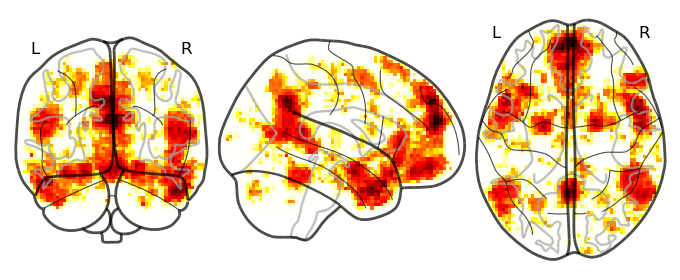

In [5]:
nsyn_map = Brain_Data(outp_dir+'/rois/social_association-test_z_FDR_0.01.nii.gz',
                  mask="derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

plot_glass_brain(nsyn_map.to_nifti())

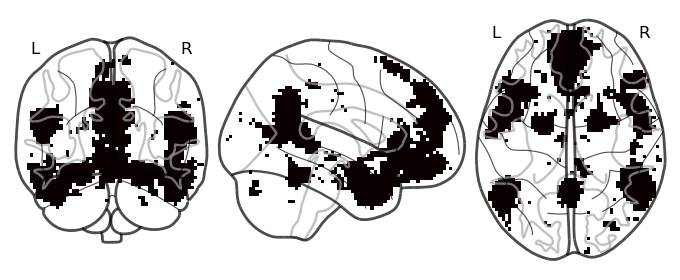

In [6]:
# Binarize for rs > 0.3
#relb_map_sm_bin = math_img('img > 0.3', img=relb_map_sm)
nsyn_map_bin = nsyn_map.threshold(upper=3, binarize=True)

# Plot and output
plot_glass_brain(nsyn_map_bin.to_nifti())
#relb_map_sm_bin.to_nifti().to_filename(data_dir+'/relb_map_sm_bin.nii.gz')

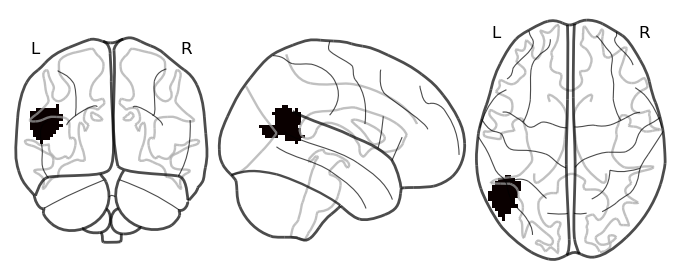

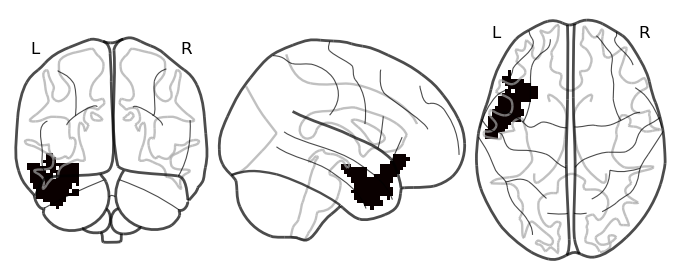

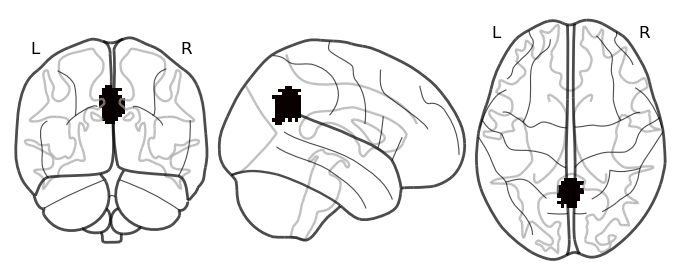

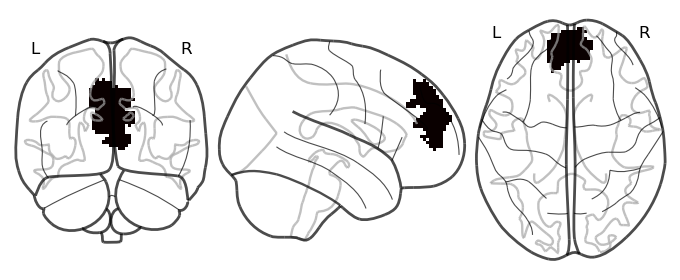

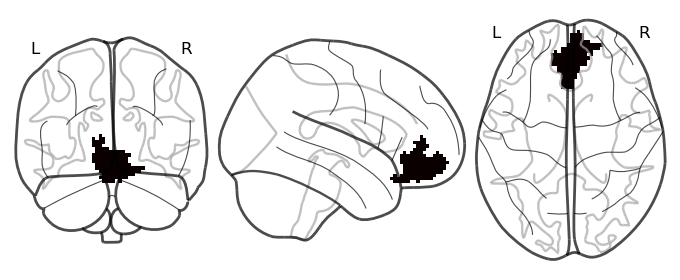

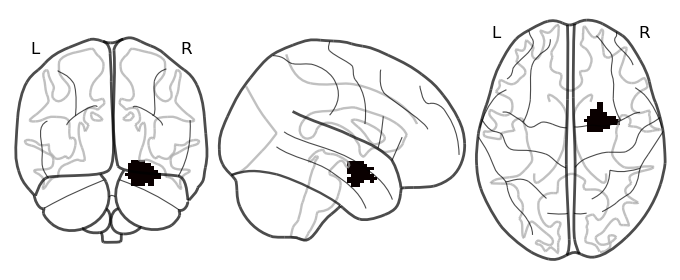

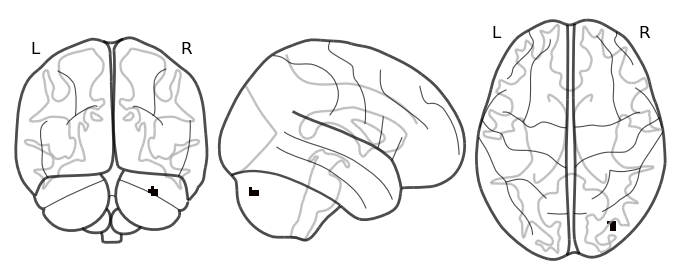

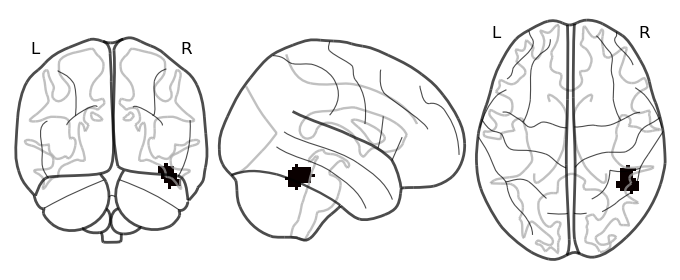

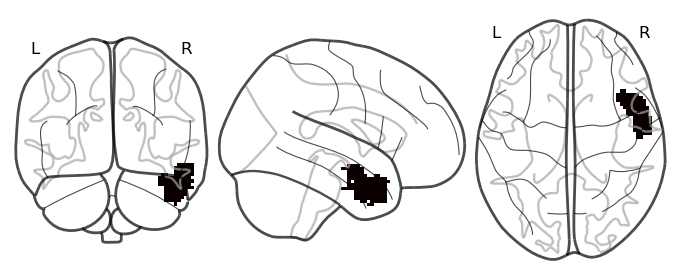

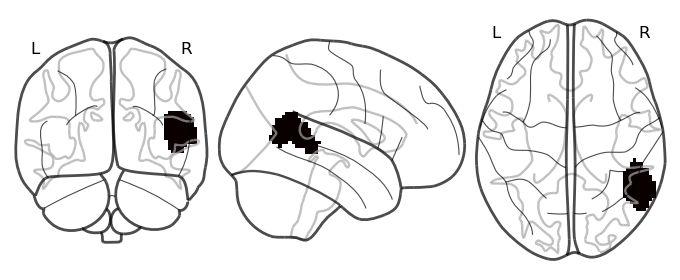

In [7]:
nsyn_rois = nsyn_map_bin.regions(min_region_size=200)

for n in range(len(nsyn_rois)):
    plot_glass_brain(nsyn_rois[n].to_nifti())

In [8]:
roi_names = ['TPJ_l', 'ATL_l', 'PCC_b', 'mPFC_b', 'vmPFC_b', 'aATL_r', 'CB_r', 'ITG_R', 'ATL_r', 'aSTS_r']

nsyn_rois_dict = {}

for n in range(len(nsyn_rois)):
    nsyn_rois_dict[roi_names[n]] = nsyn_rois[n]
    nsyn_rois_dict[roi_names[n]].to_nifti().to_filename(outp_dir+'/rois/roi_bin_'+roi_names[n]+'.nii.gz')

In [9]:
nsyn_rois_dict['TPJ_l']

nltools.data.brain_data.Brain_Data(data=(132040,), Y=0, X=(0, 0), mask=sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz)

In [10]:
# Import the Suit package
import SUITPy.flatmap as flatmap
import matplotlib.pyplot as plt
import nibabel as nb
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
funcdata = flatmap.vol_to_surf(outp_dir+'/rois/roi_bin_CB_r.nii.gz')
print('Output is a np.array of size:',funcdata.shape)

Output is a np.array of size: (28935, 1)


<AxesSubplot:>

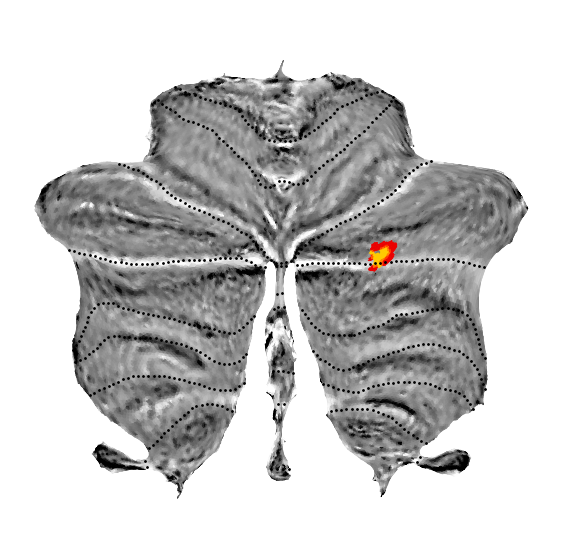

In [12]:
cb_flatmap = flatmap.plot(data=funcdata, cmap='hot', \
                        threshold=[0,0.5], \
                        new_figure=True, \
                        colorbar=False, \
                        render='matplotlib')

cb_flatmap.figure.savefig(outp_dir+'/rois/cb_roi_flatmap.png')

cb_flatmap

Text(0.5, 0, 'Time (TRs)')

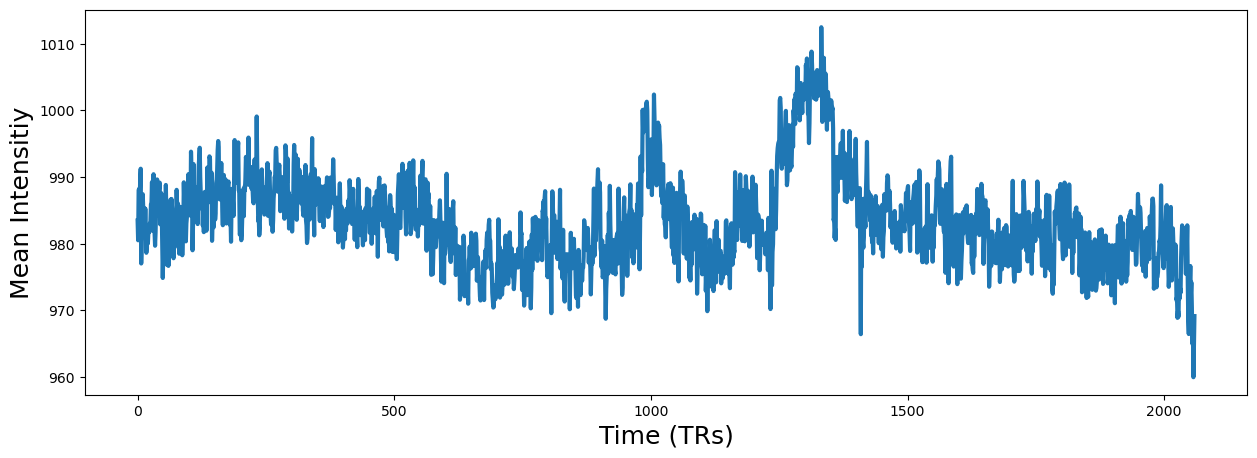

In [13]:
cb_data = smoothed.extract_roi(mask=nsyn_rois_dict['CB_r'])

plt.figure(figsize=(15,5))
plt.plot(cb_data, linewidth=3)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

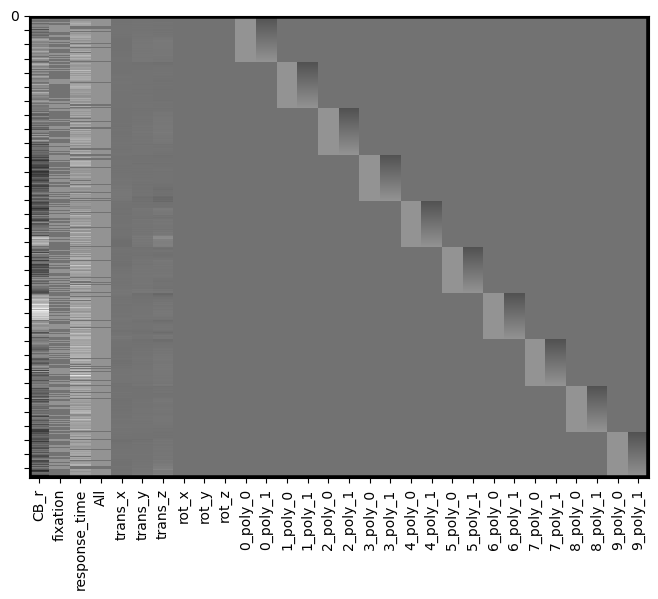

In [14]:
#tr = layout.get_tr()
tr = 2.5
n_tr = len(data)

cb_data = zscore(pd.DataFrame(cb_data, columns=['CB_r']))


#dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
# Append run design matrices
dm = pd.DataFrame()
for n in func_run_nums:
    # Import design matrix for a single run
    temp_dm = pd.read_csv(outp_dir+'/design_matrices/sub-301_ses-001_task-relscenarios_run-'+str(n)+'_desc-design_matrix.csv')
    
    # Rename the first and second order polynomial regressors so that they do not 
    # regressor between runs
    temp_dm = temp_dm.rename(columns={"poly_0": str(n-1)+"_poly_0", "poly_1": str(n-1)+"_poly_1"})
    
    # Append design matrix into a longer design matrix
    dm = dm.append(temp_dm, ignore_index=True)
#dm = dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'csf', 'white_matter']]
#dm['csf'] = zscore(dm['csf'])
#dm['white_matter'] = zscore(dm['white_matter'])

# Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
dm = dm.fillna(0)

# Join Design matrix with roi time course
dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)

#dm = dm.add_poly(order=2, include_lower=True)

# Plot design matrix
dm.heatmap()

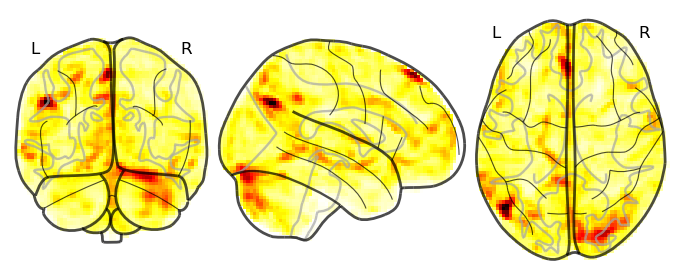

In [15]:
#dm_conv = dm.convolve()

smoothed.X = dm

stats = smoothed.regress()

CB_r_conn = stats['beta'][0]

#CB_r_conn.threshold(upper=10, lower=-10).plot()
plot_glass_brain(CB_r_conn.to_nifti())

# Psychophysiological Interactions

## Create Design Matrix for PPI

In [16]:
#dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
#dm = dm[dm['0_poly_0'] == 1]

In [17]:
#cb_data_dm = Design_Matrix(cb_data, sampling_freq=1/tr).convolve()

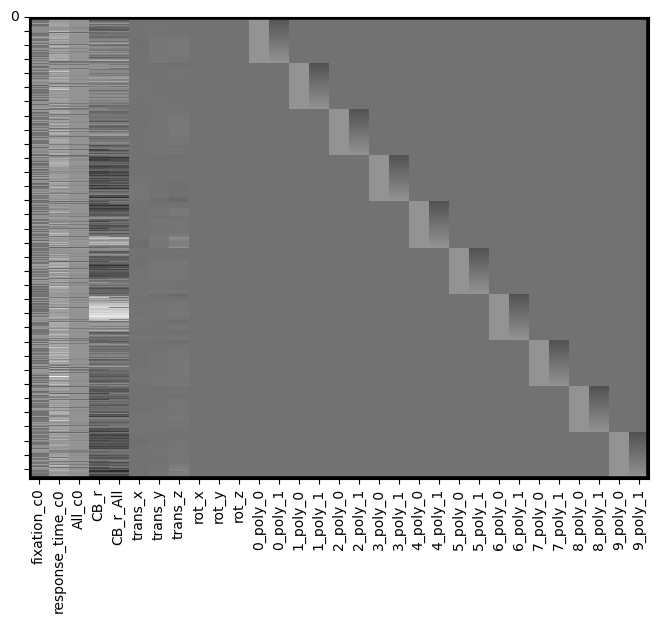

In [18]:
ppi_dm = dm.drop(['CB_r'], axis=1)

mc_cov = ppi_dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
poly_cov = ppi_dm.loc[:, ppi_dm.columns.str.contains('_poly_')]

ppi_dm = ppi_dm.drop(mc_cov.columns, axis=1)
ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)

ppi_dm_conv = ppi_dm.convolve()

ppi_dm_conv['CB_r'] = cb_data

ppi_dm_conv['CB_r_All'] = ppi_dm_conv['CB_r']*ppi_dm_conv['All_c0']

ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)


ppi_dm_conv_all.heatmap()

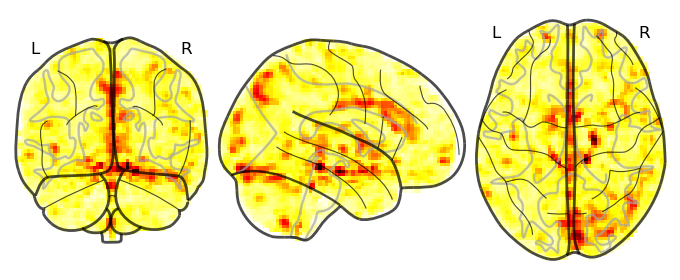

In [19]:
smoothed.X = ppi_dm_conv_all

ppi_stats = smoothed.regress()

cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='CB_r_All')[0][0])]

#cb_r_fixation_ppi.plot()
plot_glass_brain(cb_r_fixation_ppi.to_nifti())

In [20]:
#cb_r_fixation_ppi


#nib.Nifti1Image(cb_r_fixation_ppi, tmaps.a.imgaffine)

#nib.save(cb_r_fixation_ppi.to_nifti(), os.path.join(outp_dir, 'test.nii.gz'))
cb_r_fixation_ppi.to_nifti().to_filename(outp_dir+'/test.nii.gz')

# Group PPI Analysis

In [21]:
all_sub_ppi_cb = Brain_Data()

for subj in subjs_list:
    print('Calculating PPI for '+subj)
    
    # Import functional runs that passed quality control
    func_run_nums =  [s.lstrip('0') for s in subjs_scan_info[subjs_scan_info['subject']==subj]['run'].str[-8:-5]]
    func_run_nums = [int(i) for i in func_run_nums]
    print('Number of functional runs for '+subj+': '+str(len(func_run_nums)))

    func_runs = []
    for n in func_run_nums:
        func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'ses-001', 'func',
                                       f'*run-'+str(n)+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])
    
    
    # Import functional data, masked for only grey matter
    subj_gm_mask = 'derivatives/reliability_analysis/relscenarios/Anatomy/sub-301_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii'
    #comn_mni_mask = "derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    data = Brain_Data(func_runs, mask=subj_gm_mask)
    
    
    # Smooth data
    fwhm=6
    smoothed = data.smooth(fwhm=fwhm)
    
    
    # Extract cerebellum ROI data
    cb_data = smoothed.extract_roi(mask=nsyn_rois_dict['CB_r'])
    
    
    # Get functional meta data
    #tr = layout.get_tr()
    n_tr = len(data)
    
    
    # Z-score cerebellum time series
    cb_data = zscore(pd.DataFrame(cb_data, columns=['CB_r']))

    
    # Import Design matrix for all runs
    #dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
    #cb_data_dm = Design_Matrix(cb_data, sampling_freq=1/tr).convolve()
    dm = pd.DataFrame()
    for n in func_run_nums:
        # Import design matrix for a single run
        temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_ses-001_task-relscenarios_run-'+str(n)+'_desc-design_matrix.csv')

        # Rename the first and second order polynomial regressors so that they do not 
        # regressor between runs
        temp_dm = temp_dm.rename(columns={"poly_0": str(n-1)+"_poly_0", "poly_1": str(n-1)+"_poly_1"})

        # Append design matrix into a longer design matrix
        dm = dm.append(temp_dm, ignore_index=True)

    # Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
    dm = dm.fillna(0)
    
    # Combine cerebellum time series with the design matrix
    #ppi_dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)
    
    
    #ppi_dm = dm.drop(['CB_r'], axis=1)

    mc_cov = dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    poly_cov = dm.loc[:, dm.columns.str.contains('_poly_')]

    ppi_dm = dm.drop(mc_cov.columns, axis=1)
    ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)
    
    ppi_dm = Design_Matrix(ppi_dm, sampling_freq=1/tr)
    ppi_dm_conv = ppi_dm.convolve()

    ppi_dm_conv['CB_r'] = cb_data

    ppi_dm_conv['CB_r_All'] = ppi_dm_conv['CB_r']*ppi_dm_conv['All_c0']

    ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)
    
    
    # Convolve design matrix
    #ppi_dm_conv = ppi_dm.convolve()
    
    
    # Calculate interaction term
    #ppi_dm_conv['CB_r_All'] = ppi_dm_conv['CB_r_c0']*ppi_dm_conv['All_c0']
    
    
    # Run PPI
    smoothed.X = ppi_dm_conv_all
    ppi_stats = smoothed.regress()
    cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='CB_r_All')[0][0])]
    
    
    # Export PPI map
    cb_r_fixation_ppi.to_nifti().to_filename(outp_dir+'/subject_results/'+subj+'_ppi_cb.nii.gz')
    
    
    # Append subject data
    all_sub_ppi_cb = all_sub_ppi_cb.append(cb_r_fixation_ppi)

Calculating PPI for sub-301
Number of functional runs for sub-301: 10
Calculating PPI for sub-651
Number of functional runs for sub-651: 10
Calculating PPI for sub-653
Number of functional runs for sub-653: 9
Calculating PPI for sub-693
Number of functional runs for sub-693: 10
Calculating PPI for sub-697
Number of functional runs for sub-697: 10
Calculating PPI for sub-699
Number of functional runs for sub-699: 10
Calculating PPI for sub-700
Number of functional runs for sub-700: 10
Calculating PPI for sub-701
Number of functional runs for sub-701: 10
Calculating PPI for sub-706
Number of functional runs for sub-706: 10
Calculating PPI for sub-715
Number of functional runs for sub-715: 10
Calculating PPI for sub-716
Number of functional runs for sub-716: 10
Calculating PPI for sub-720
Number of functional runs for sub-720: 10
Calculating PPI for sub-721
Number of functional runs for sub-721: 10
Calculating PPI for sub-722
Number of functional runs for sub-722: 10
Calculating PPI for s

## Group Average

In [22]:
stats_all = all_sub_ppi_cb.ttest(threshold_dict={'fdr':.05})
stats_all['t'].write(os.path.join(outp_dir, 'group_results', 'tmap_ppi_cb_unc.nii.gz'))
stats_all['thr_t'].write(os.path.join(outp_dir, 'group_results', 'tmap_ppi_cb_fdr05.nii.gz'))


/home/local/TU/tuk12127/.local/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


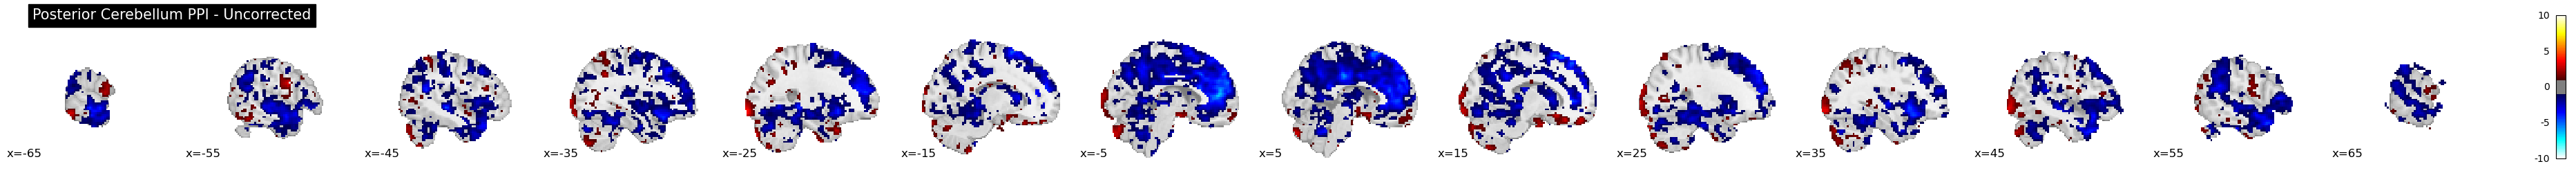

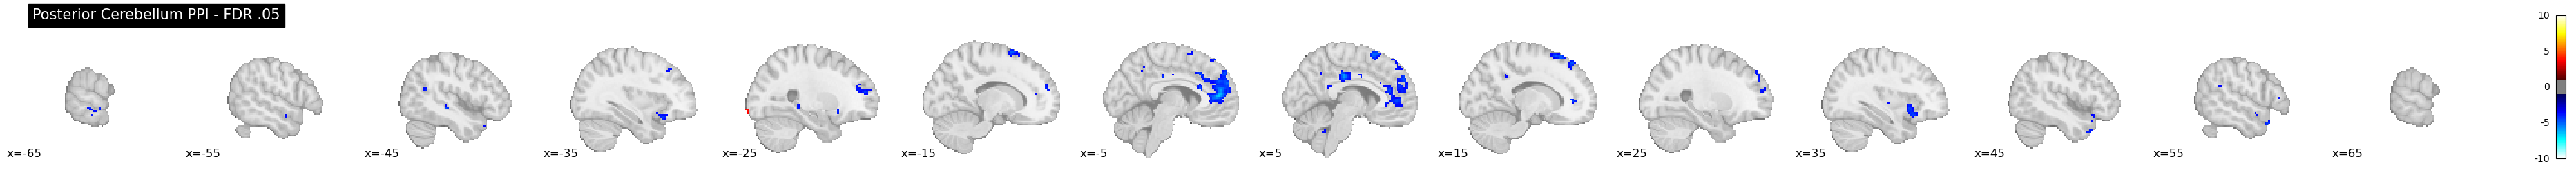

In [23]:
plot_stat_map(stats_all['t'].to_nifti(), threshold=1,
    cut_coords=range(-65, 66, 10), display_mode='x', vmax=10, colorbar=True,
    title='Posterior Cerebellum PPI - Uncorrected')

results_plot = plot_stat_map(stats_all['thr_t'].to_nifti(), threshold=1,
                cut_coords=range(-65, 66, 10), display_mode='x', vmax=10, colorbar=True,
                title='Posterior Cerebellum PPI - FDR .05')
results_plot

results_plot.savefig(outp_dir+'/group_results/tmap_ppi_cb_fdr05.png')

In [24]:
from nilearn import plotting
from nilearn import surface
from nilearn import datasets

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


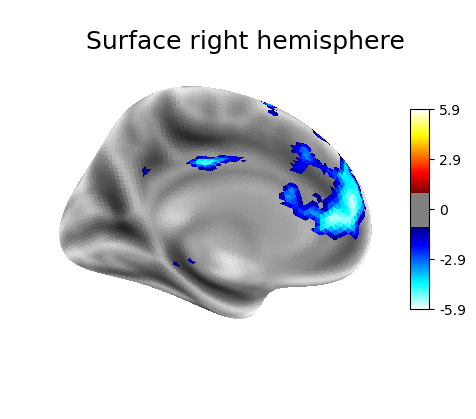

In [25]:
fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(stats_all['thr_t'].to_nifti(), fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=1.,
                                     bg_map=fsaverage.sulc_left)

figure.show()

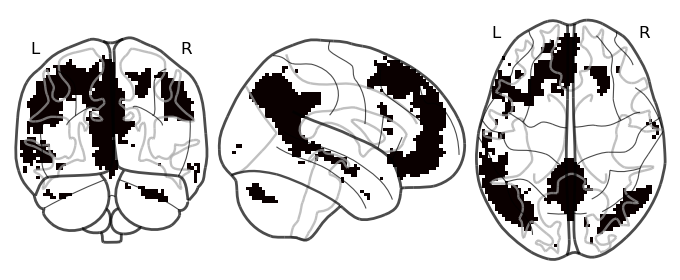

In [26]:
relb_map_sm_bin = Brain_Data(bids_dir+'/derivatives/reliability_analysis/3-Results/relscenarios/Step1-Reliability/relb_map_sm_bin.nii.gz',
                  mask="derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

plot_glass_brain(relb_map_sm_bin.to_nifti())

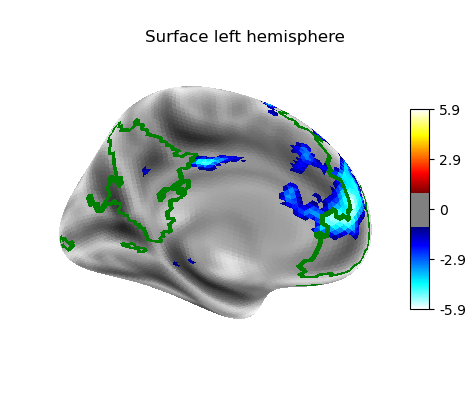

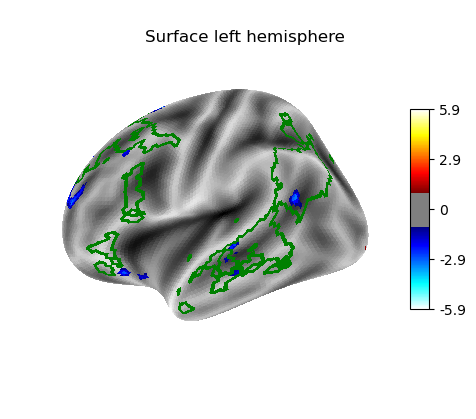

In [27]:
texture = surface.vol_to_surf(stats_all['thr_t'].to_nifti(), fsaverage.pial_left)

roi_surf_map = surface.vol_to_surf(relb_map_sm_bin.to_nifti(), fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                                     title='Surface left hemisphere',
                                     view='medial',
                                     colorbar=True, threshold=1.,
                                     bg_map=fsaverage.sulc_left)

plotting.plot_surf_contours(fsaverage.infl_left, roi_map=roi_surf_map, figure=figure,
                           colors=['g'], labels=['test'], levels=[0])
plotting.show()


figure = plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                                     title='Surface left hemisphere',
                                     view='lateral',
                                     colorbar=True, threshold=1.,
                                     bg_map=fsaverage.sulc_left)

plotting.plot_surf_contours(fsaverage.infl_left, roi_map=roi_surf_map, figure=figure,
                           colors=['g'], labels=['test'], levels=[0])
plotting.show()

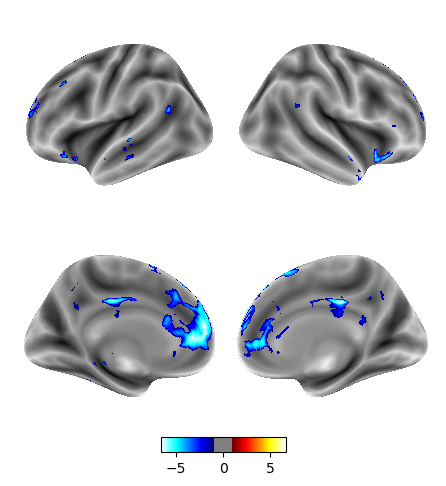

In [28]:
plotting.plot_img_on_surf(stats_all['thr_t'].to_nifti(),
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=1.0,
                          surf_mesh='fsaverage',
                          #cmap='blue_orange',
                          colorbar=True)

plotting.show()

In [29]:
plotting.plot_img_on_surf(stats_all['thr_t'].to_nifti(),
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=1.0,
                          surf_mesh='fsaverage',
                          #cmap='blue_orange',
                          colorbar=True,
                          output_file=outp_dir+'/group_results/tmap_ppi_cb_fdr05_surf.png')



In [30]:
time_course_data = pd.DataFrame()
time_course_data['CB_r'] = smoothed.extract_roi(mask=nsyn_rois_dict['CB_r'])
time_course_data['mPFC_b'] = smoothed.extract_roi(mask=nsyn_rois_dict['mPFC_b'])

time_course_data = zscore(time_course_data)
time_course_data

,CB_r,mPFC_b
0,-2.225290,-0.289672
1,-2.483704,-0.740943
2,-2.467988,-0.794736
3,-1.973852,-0.998454
4,-1.445293,-0.635957
...,...,...
1025,1.691929,-0.465177
1026,1.274601,-0.443609
1027,1.140557,-0.387426
1028,0.674240,-0.050837


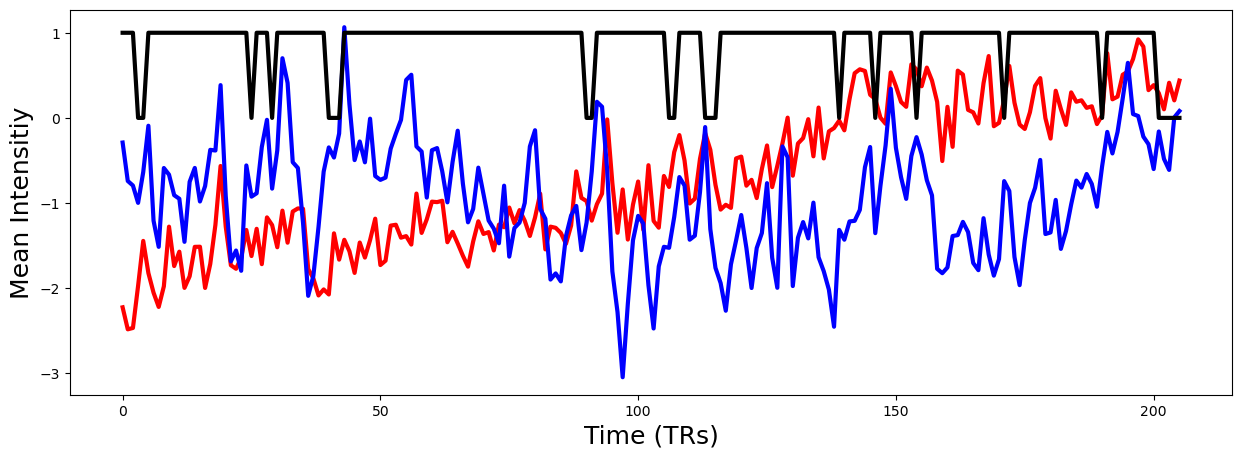

In [31]:
plt.figure(figsize=(15,5))
plt.plot(time_course_data['CB_r'].iloc[:206], linewidth=3, color='red')
plt.plot(time_course_data['mPFC_b'].iloc[:206], linewidth=3, color='blue')
plt.plot(dm['All'].iloc[:206], linewidth=3, color='black')
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

plt.savefig(outp_dir+'/example_timecourse.png')